# HDR
* b03902089 林良翰
* b03902032 周家宇

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path as osp
import os
import random
from timer import Timer

In [2]:
t = Timer()

In [3]:
mse = lambda a, b: np.mean((a - b) ** 2)
rmse = lambda a, b: np.sqrt(mse(a, b))

## Read images

In [7]:
dirname = 'memorial'

images, images_rgb = [], []

for filename in np.sort(os.listdir(dirname)):
    if osp.splitext(filename)[1] in ['.png', '.jpg']:
        im = cv2.imread(osp.join(dirname, filename))
        images += [im]
        images_rgb += [cv2.cvtColor(im, cv2.COLOR_BGR2RGB)]

# number of images
P = len(images)
print('P =', P)

height, width, channel = images[0].shape
print('image shape:', images[0].shape)

P = 16
image shape: (768, 512, 3)


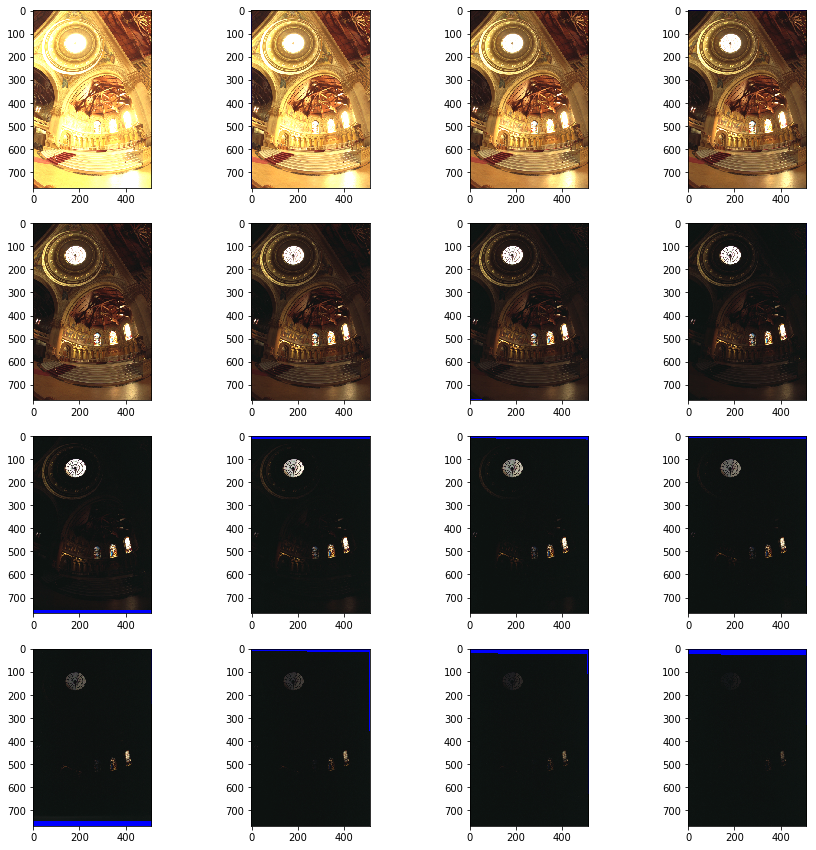

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for p in range(P):
    row = int(p / 4)
    col = int(p % 4)
    ax[row, col].imshow(images_rgb[p])
plt.show()

In [9]:
#shutter_times = np.array([1/90., 1/60., 1/45., 1/30., 
#                         1/20., 1/15., 1/10.,  1/8., 
#                           1/6.,  1/4.,  1/3.,  1/2., 
#                          1/1.5,    1.,   1.5,    2.], dtype=np.float32)
shutter_speed = np.array([1/32, 1/16, 1/8., 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], dtype=np.float32)
shutter_times = 1 / shutter_speed
Ln_st = np.log(shutter_times).astype(np.float32)

## HDR Radiance Map (cv2 package)

In [143]:
#alignMTB = cv2.createAlignMTB()
#alignMTB.process(images, images)

calibrateDebevec = cv2.createCalibrateDebevec()
G_bgr_cv2 = calibrateDebevec.process(images, shutter_times)

mergeDebevec = cv2.createMergeDebevec()
radiance_debevec_cv2 = mergeDebevec.process(images, shutter_times, G_bgr_cv2)

## Image Alignment
* dx: right positive
* dy: down positive

In [169]:
def translationMatrix(dx, dy):
    M = np.float32([[1, 0, dx],
                    [0, 1, dy]])
    return M

def findShift(src, tar, x, y, thres=4):
    h, w = tar.shape[:2]
    min_error = np.inf
    best_dx, best_dy = 0, 0
    
    median = np.median(src)
    ignore_pixels = np.ones(src.shape)
    ignore_pixels[np.where(np.abs(src - median) <= thres)] = 0
    
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            tmp_src = cv2.warpAffine(src, translationMatrix(x + dx, y + dy), (w, h))
            
            error = np.abs(np.sign(tmp_src - tar))
            error = np.sum(error * ignore_pixels)
            
            if error < min_error:
                min_error = error
                best_dx, best_dy = dx, dy
    
    return x + best_dx, y + best_dy
            
def imageAlignment(src, tar, depth=6):
    if depth == 0:
        dx, dy = findShift(src, tar, 0, 0)
        
    else:
        h, w = src.shape[:2]
        half_src = cv2.resize(src, (w//2, h//2))
        half_tar = cv2.resize(tar, (w//2, h//2))
        prev_dx, prev_dy = imageAlignment(half_src, half_tar, depth-1)
        dx, dy = findShift(src, tar, prev_dx * 2, prev_dy * 2)

    return dx, dy

In [172]:
# test image alignment
test_image = np.array(images[0]) # your custom input

target = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
h, w = target.shape[:2]

# shift x +2, y -2
source = cv2.warpAffine(target, translationMatrix(2, -2), (w, h))

# result should be x -2, y +2
print('result:', imageAlignment(source, target))

result: (-2, 2)


## HDR Radiance Map (self)

**Select sample points**

In [10]:
N = 200
random.seed(1208)
indices = np.array(random.sample(range(height * width), N))
print('# samples per image =', N)

xv = indices % width
yv = indices // height
Z_bgr = [[images[p][yv, xv, c] for p in range(P)] for c in range(3)]

Z_all_bgr = [[images[p][:, :, c] for p in range(P)] for c in range(3)]

# samples per image = 200


**Weights**
* 0 uniform
* 1 triangle
* 2 relu
* 3 gaussian

In [11]:
weight_type=1

In [12]:
gaussian = lambda x, mu, s: 1 / (s * (2 * np.pi) ** (1/2)) * np.exp(-(x - mu) ** 2 / (2 * s ** 2))

def weights_relu(Z, p):
        w = np.zeros(256, dtype=np.float32)
        zmid = np.ceil(np.mean(Z)).astype(int)
        if p == 0:
            w[zmid:] = np.arange(256-zmid, dtype=np.float32) / (256-zmid)
        elif p == 1:
            return getWeights(Z, wtype=1)
        elif p == 2:
            w[:zmid] = np.arange(zmid, dtype=np.float32)[::-1] / zmid
        return w[Z]

def getWeights(Z, wtype=1, p=0, mean=128, sigma=128):
    if wtype == 1:
        weights = np.concatenate((np.arange(1, 129), np.arange(1, 129)[::-1]), axis=0) * 4
        return weights[Z].astype(np.float32)
    
    elif wtype == 2:
        if len(Z) == P * N:
            weights = np.zeros_like(Z).astype(np.float32)
            for p in range(P):
                weights[p * N : p * N + N] = weights_relu(Z[p * N : p * N + N], p)
            return weights
        else:
            return weights_relu(Z, p)
    
    elif wtype == 3:
        w = np.arange(256)
        return gaussian(w, mean, sigma)[Z]
    
    else:
        return np.ones(Z.shape, dtype=np.float32)

### 1. Paul Debevec's method

In [13]:
def constructA(cols, rows, W, Ln_st, N, P, constraint, lamda):
    A = np.zeros([N * P + 255, 256 + N])
    
    A[cols, rows] = W
    
    for p in range(P):
        A[p * N : p * N + N, 256:] = -np.identity(N) * W[p * N : p * N + N]
        
    for i in range(254):
        A[N * P + i, i : i + 3] = np.array([1, -2, 1]) * np.abs(i - 127) * lamda
        
    A[-1, constraint] = 1
    
    return A.astype(np.float32)

def constructB(cols, rows, W, Ln_st, N, P):
    B = np.zeros(N * P + 255)
    
    for p in range(P):
        B[p * N : p * N + N] = Ln_st[p]
        
    B[cols] *= W
    
    return B.astype(np.float32)
    
def constructMatrix(samples, Ln_shutter_times, num_samples, num_images, constraint=127, lamda=10):
    Z = samples
    Ln_st = Ln_shutter_times
    N = num_samples
    P = num_images
    
    cols = np.arange(N * P)
    rows = np.array(Z).flatten()
    
    W = getWeights(rows, wtype=weight_type)
    
    A = constructA(cols, rows, W, Ln_st, N, P, constraint, lamda)
    B = constructB(cols, rows, W, Ln_st, N, P)
    
    return A, B

In [14]:
def debevecMethod(Z, Ln_st, N, P):
    A, B = constructMatrix(Z, Ln_st, N, P, constraint=127)
    A_inv = np.linalg.pinv(A)
    lnG = np.dot(A_inv, B)[:256]
    print('A_inv solved:', A_inv.shape)
    
    return lnG

**Compute Radiance Map**

In [15]:
LnG_bgr_debevec = [debevecMethod(Z, Ln_st, N, P) for Z in Z_bgr]

A_inv solved: (456, 3455)
A_inv solved: (456, 3455)
A_inv solved: (456, 3455)


**Display Radiance Map**

In [16]:
def fmt(x, pos):
    return '%.3f' % np.exp(x)

# G_bgr need to be log
def displayRadiance(images, LnG_bgr, weight_type):
    Ln_radiance_bgr = np.zeros([height, width, 3]).astype(np.float32)

    P = len(images)
    
    plt.clf()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    bgr_string = ['blue', 'green', 'red']

    for c in range(3):

        W_sum = np.zeros([height, width], dtype=np.float32)
        Ln_radiance_sum = np.zeros([height, width], dtype=np.float32)

        for p in range(P):
            
            #print('color=' + bgr_string[c] + ', st=%.4f' % (shutter_times[p]))
            
            im_1D = images[p][:, :, c].flatten()
            Ln_radiance = (LnG_bgr[c][im_1D] - Ln_st[p]).reshape(height, width)

            weights = getWeights(im_1D, wtype=weight_type, p=p).reshape(height, width)
            w_Ln_radiance = Ln_radiance * weights
            Ln_radiance_sum += w_Ln_radiance
            W_sum += weights

            #axes[p, c].imshow(w_Ln_radiance, cmap='jet', interpolation='nearest', aspect='auto')
            #axes[p, c].set_title('dt=%.4f' % shutter_times[p] + ', ' + bgr_string[c])

        weighted_Ln_radiance = Ln_radiance_sum / W_sum
        Ln_radiance_bgr[:, :, c] = weighted_Ln_radiance
        
        ax = axes[c]
        im = ax.imshow(weighted_Ln_radiance, cmap='jet')
        ax.set_title(bgr_string[c])
        ax.set_axis_off()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(fmt))

    radiance_bgr = np.exp(Ln_radiance_bgr)
    print(np.max(radiance_bgr) / np.min(radiance_bgr))
    
    fig.savefig('radiance_debevec.png', bbox_inches='tight', dpi=256)
    cv2.imwrite('radiance_debecvec.hdr', radiance_bgr.astype(np.float32))
    
    return np.exp(Ln_radiance_bgr)

663588.5


<Figure size 432x288 with 0 Axes>

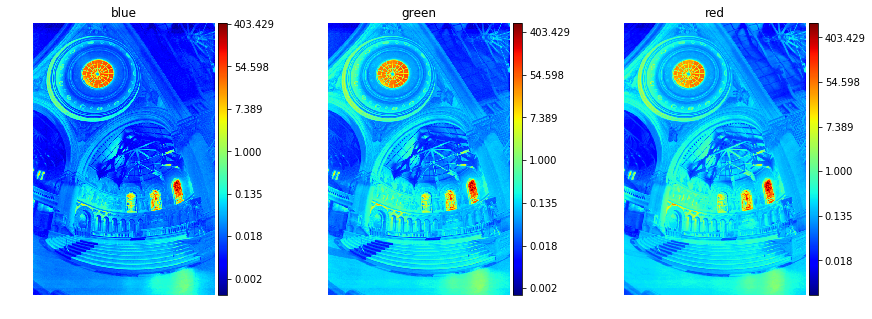

In [17]:
radiance_debevec = displayRadiance(images, LnG_bgr_debevec, weight_type)

**Display Response Curve**

In [21]:
def displayResponseCurve(LnG_bgr):
    bgr_string = ['blue', 'green', 'red']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for c in range(3):
        ax = axes[c]
        ax.plot(LnG_bgr[c], np.arange(256), c=bgr_string[c])
        ax.set_title(bgr_string[c])
        ax.set_xlabel('E: Log Exposure')
        ax.set_ylabel('Z: Pixel Value')
        ax.grid(linestyle=':', linewidth=1)
    fig.savefig('response_curve.png', bbox_inches='tight', dpi=256)

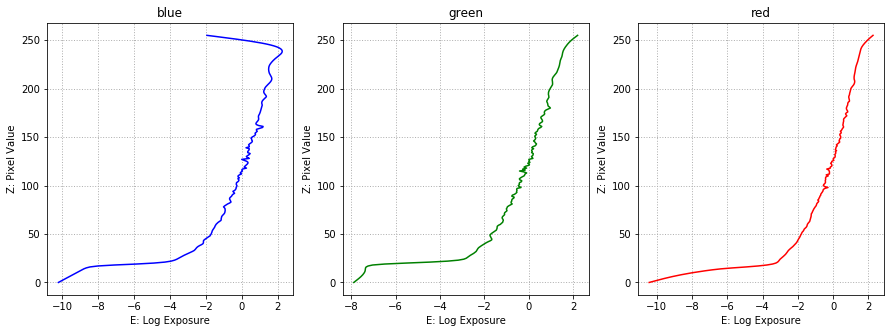

In [22]:
displayResponseCurve(LnG_bgr_debevec)

### 2. Robertson's method

In [162]:
def fitE(Z, G, st):
    Wz = getWeights(Z, wtype=weight_type).reshape(P, -1) / 128
    Gz = G[Z].reshape(P, -1)
    
    upper = np.sum(Wz * Gz * st, axis=0).astype(np.float32)
    bottom = np.sum(Wz * st * st, axis=0).astype(np.float32) + 1e-8
    return upper / bottom

def fitG(Z, G, E, st):
    Z = Z.reshape(P, -1)
    Wz = getWeights(Z, wtype=weight_type).reshape(P, -1) / 128
    Wz_Em_st = Wz * (E * st)
    
    for m in range(256):
        index = np.where(Z == m)
        upper = np.sum(Wz_Em_st[index]).astype(np.float32)
        lower = np.sum(Wz[index]).astype(np.float32) + 1e-8
        if lower > 0:
            G[m] = upper / lower
            
    G /= G[127]
    return G

# initG not need to be log
def robertsonMethod(Z_bgr, initG, epochs=2):
    G_bgr = np.array(initG)
    st = shutter_times.reshape(P, 1)
    
    for c in range(3):
        Z = np.array(Z_bgr[c])
        G = np.array(initG[c])
        
        for e in range(epochs):
            print('\rcolor=%d, epoch=%d' % (c, e), end='    ')
            # Compute Ei (energy of each pixel)
            E = fitE(Z, G, st)
            # Compute Gm
            G = fitG(Z, G, E, st)

        G_bgr[c] = G
        
    return G_bgr.astype(np.float32)

color=2, epoch=4    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


24357.986


<Figure size 432x288 with 0 Axes>

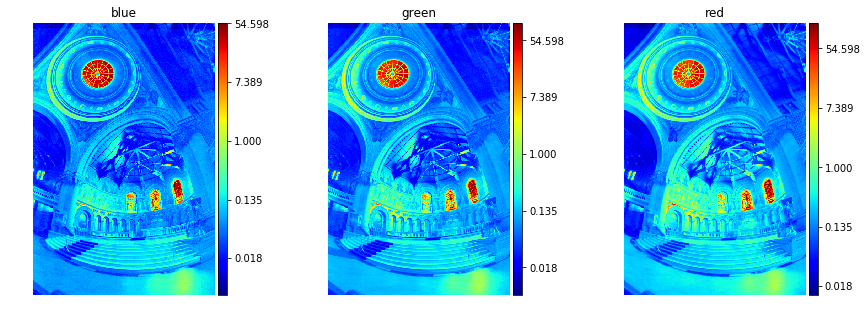

In [203]:
G_bgr_robertson = robertsonMethod(Z_all_bgr, [np.arange(0, 1, 1 / 256)] * 3, epochs=5)
radiance_robertson = displayRadiance(images, np.log(G_bgr_robertson), weight_type)

### Difference between Debevec & Robertson

In [164]:
mse(radiance_robertson, radiance_debevec)

6.854809

## Tone Mapping

**cv2 packages**

In [30]:
radiance = radiance_debevec

tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(radiance)
cv2.imwrite("tonemap_drago.jpg", ldrDrago * 255 * 3)

tonemapDurand = cv2.createTonemapDurand(1.5, 4, 1.0, 1, 1)
ldrDurand = tonemapDurand.process(radiance)
cv2.imwrite("tonemap_durand.jpg", ldrDurand * 255 * 3)

tonemapReinhard = cv2.createTonemapReinhard(1, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(radiance)
cv2.imwrite("tonemap_reinhard.jpg", ldrReinhard * 255 * 3)

tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(radiance)
cv2.imwrite("tonemap_mantiuk.jpg", ldrMantiuk * 255 * 3)

True

**Photographic Tone Reproduction**

A. global

In [205]:
# d: log zero avoidance
# a: average key

def photographicGlobal(radiance, d=1e-6, a=0.5):
    Lw = radiance
    Lw_ave = np.exp(np.mean(np.log(d + Lw)))
    Lm = (a / Lw_ave) * Lw
    Lm_max = np.max(Lm) # Lm_white
    Ld = (Lm * (1 + (Lm / (Lm_max ** 2)))) / (1 + Lm)
    result = np.clip(np.array(Ld * 255), 0, 255).astype(np.uint8)

    cv2.imwrite("tonemap_photographic_global.jpg", result)
    return result

In [206]:
res = photographicGlobal(radiance_debevec)

In [70]:
res = photographicGlobal(radiance_robertson)

B. local

In [241]:
# a: average key
# fi: sharpening
# epsilon: threshold of smoothness

def gaussianBlurs(im, smax=25, a=1.0, fi=8.0, epsilon=0.01):
    cols, rows = im.shape
    blur_prev = im
    num_s = int((smax+1)/2)
    
    blur_list = np.zeros(im.shape + (num_s,))
    Vs_list = np.zeros(im.shape + (num_s,))
    
    for i, s in enumerate(range(1, smax+1, 2)):
        print('\rfilter:', s, end='')
        blur = cv2.GaussianBlur(im, (s, s), 0)
        Vs = np.abs((blur - blur_prev) / (2 ** fi * a / s ** 2 + blur_prev))
        blur_list[:, :, i] = blur
        Vs_list[:, :, i] = Vs
    print()
    
    # 2D index
    print('find index...')
    smax = np.argmax(Vs_list > epsilon, axis=2)
    smax[np.where(smax == 0)] = 1
    smax -= 1
    
    # select blur size for each pixel
    print('apply index...')
    I, J = np.ogrid[:cols, :rows]
    blur_smax = blur_list[I, J, smax]

    return blur_smax

def photographicLocal(radiance, d=1e-6, a=0.5, method=0):
    result = np.zeros_like(radiance, dtype=np.float32)
    weights = [0.065, 0.67, 0.265]
    
    if method == 0:
        Lw_ave = np.exp(np.mean(np.log(d + radiance)))
        
        for c in range(3):
            Lw = radiance[:, :, c]
            Lm = (a / Lw_ave) * Lw
            Ls = gaussianBlurs(Lm)
            Ld = Lm / (1 + Ls)
            result[:, :, c] = np.clip(np.array(Ld * 255), 0, 255).astype(np.uint8)
    
    elif method == 1:
        Lw = 0.065 * radiance[:, :, 0] + 0.67 * radiance[:, :, 1] + 0.265 * radiance[:, :, 2]
        Lw_ave = np.exp(np.mean(np.log(d + Lw)))
        Lm = (a / Lw_ave) * Lw
        Ls = gaussianBlurs(Lm)
        Ld = Lm / (1 + Ls)
        
        for c in range(3):
            result[:, :, c] = np.clip(np.array((Ld / Lw) * radiance[:, :, c] * 255), 0, 255).astype(np.uint8)

    cv2.imwrite("tonemap_photographic_local.jpg", result)
    return result

In [243]:
res = photographicLocal(radiance_debevec)

color: 0
filter: 25
find index...
apply index...
color: 1
filter: 25
find index...
apply index...
color: 2
filter: 25
find index...
apply index...


In [126]:
res = photographicLocal(radiance_robertson)

In [28]:
np.log(2, 2)

TypeError: return arrays must be of ArrayType